DATA PREPROCESSING

In [8]:
import pandas as pd
import os.path
import numpy as np
import sklearn.linear_model as lm
import sklearn.ensemble as se
import sklearn.metrics as sm
import sklearn.model_selection as sms
import sklearn.preprocessing as spr
import sklearn.neighbors as sn
import xgboost as xgb
import matplotlib.pyplot as pyplt
import sklearn.preprocessing as sp
import sklearn.feature_selection as fs
import boruta as bt
import optuna
import seaborn as sns
import sklearn.svm as supvec
from IPython.display import clear_output
import warnings
import pickle
warnings.simplefilter('ignore')
np.random.seed(42)

np.int = np.int64
np.float = np.float64
np.bool = np.bool_

SKF = sms.StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

def encoder_funct(y):
    key_map = {}
    unique_list = y.unique()
    for i in range(len(unique_list)):
        key_map[unique_list[i]] = i
    return key_map

def reverse_map(map):
    rev_map = {}
    for i in map.keys():
        rev_map[map[i]] = i
    return rev_map

df_leuk = pd.read_csv("databases/Leukemia_GSE28497.csv")
df_br = pd.read_csv("databases/Brain_GSE50161.csv")

df_leuk.drop(df_leuk.loc[df_leuk["type"]=="normal"].index, inplace=True)
df_br.drop(df_br.loc[df_br["type"]=="normal"].index, inplace=True)

key_map = {"leukemia_type" : encoder_funct(df_leuk["type"]), "brain_type" : encoder_funct(df_br["type"])}
inv_key_map = {"leukemia_type" : reverse_map(key_map["leukemia_type"]), "brain_type" : reverse_map(key_map["brain_type"])}

df_leuk.replace({"type" : key_map["leukemia_type"]}, inplace=True)
df_br.replace({"type" : key_map["brain_type"]}, inplace=True)

X_leukemia_type = df_leuk.drop(["type", "samples"], axis=1)
y_leukemia_type = df_leuk["type"]

X_brain_type = df_br.drop(["type", "samples"], axis=1)
y_brain_type = df_br["type"]

print(X_leukemia_type.shape)
print(X_brain_type.shape)

leukemia_classes = list(y_leukemia_type.unique())
brain_classes = list(y_brain_type.unique())

(281, 22283)
(117, 54675)


MODELLING PIPELINE

In [2]:
def RandomForestClassifier_trial_data(trial):
    return {"n_estimators" : trial.suggest_int("n_estimators", 10, 2000, log=True),
            "max_depth" : trial.suggest_int("max_depth", 1, 20),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 20),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 2, 20),
            "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 0, 0.1),
            "min_weight_fraction_leaf" : trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
            "random_state" : 42,
            "max_features" : trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap" : trial.suggest_categorical("bootstrap", [True, False])}

def XGBoostClassifier_trial_data(trial):
    return {"booster" : "gbtree",
            "n_estimators" : trial.suggest_int("n_estimators", 10, 2000, log=True),
            "max_depth" : trial.suggest_int("max_depth", 1, 10),
            "max_delta_step" : trial.suggest_float("max_delta_step", 0, 10),
            "learning_rate" : trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
            "alpha" : trial.suggest_float("alpha", 0.01, 100, log=True),
            "gamma" : trial.suggest_float("gamma", 0.01, 1, log=True),
            "lambda" : trial.suggest_float("lambda", 0.01, 100, log=True),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.1, 1),
            "colsample_bylevel" : trial.suggest_float("colsample_bytree", 0.1, 1),
            "random_state" : 42}

def ExtraTreesClassifier_trial_data(trial):
    return {"n_estimators" : trial.suggest_int("n_estimators", 10, 2000, log=True),
            "max_depth" : trial.suggest_int("max_depth", 1, 20),
            "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 20),
            "min_weight_fraction_leaf" : trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 2, 20),
            "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 0, 0.1),
            "warm_start" : trial.suggest_categorical("warm_start", [True, False]),
            "class_weight" : trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample", None]),
            "random_state" : 42,
            "max_features" : trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap" : trial.suggest_categorical("bootstrap", [True, False])}

def optuna_trial_parametrized(trial, model_name):
    match model_name:
        case "RandomForestClassifier":
            return se.RandomForestClassifier(**(RandomForestClassifier_trial_data(trial)))
        case "XGBoostClassifier":
            return xgb.XGBClassifier(**(XGBoostClassifier_trial_data(trial)))
        case "ExtraTreesClassifier":
            return se.ExtraTreesClassifier(**(ExtraTreesClassifier_trial_data(trial)))
    return None

def best_param_parametrized(params, model_name):
    match model_name:
        case "RandomForestClassifier":
            return se.RandomForestClassifier(**params)
        case "XGBoostClassifier":
            return xgb.XGBClassifier(**params)
        case "ExtraTreesClassifier":
            return se.ExtraTreesClassifier(**params)
    return None

def feature_selection(X, y):
    fs_kbest = fs.SelectKBest(fs.mutual_info_classif, k=10000).fit(X, y)
    sel_feat_mutual = list(fs_kbest.get_feature_names_out())
    X_mutual = X[sel_feat_mutual]
    fs_estimator = xgb.XGBClassifier(random_state=42)
    fs_boruta = bt.BorutaPy(fs_estimator, n_estimators="auto", verbose=2, random_state=42, perc=80).fit(X_mutual.to_numpy(), y.to_numpy())
    return list(X_mutual.columns[fs_boruta.support_ | fs_boruta.support_weak_])

def hyperparameter_optimization(X, y, model_name):
    def objective(trial):
        model = optuna_trial_parametrized(trial, model_name)
        score_list = sms.cross_validate(model, X, y, cv=SKF, scoring=("accuracy", "f1_weighted", "roc_auc_ovr_weighted"), n_jobs=-1)
        return (np.mean(score_list["test_accuracy"]) + np.mean(score_list["test_f1_weighted"]) + 5*np.mean(score_list["test_roc_auc_ovr_weighted"]))
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=50, n_jobs=-1)
    return study.best_params

def pipeline(X, y, model_name, database_name, classes, decoder):

  train_X, test_X, train_y, test_y = sms.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

  feature_file = "features/selected_features_"+database_name+".pkl"
  if(os.path.isfile(feature_file) == False):
    selected_features = feature_selection(train_X, train_y)
    output = open(feature_file, "wb")
    pickle.dump(selected_features, output)
    output.close()
  selected_features = pd.read_pickle(feature_file)
  train_X = train_X[selected_features]
  test_X = test_X[selected_features]

  # Hyperparameter optimization in pipeline

  hyper_file = "hyperparameters/hyperparameters_"+database_name+"_"+model_name+".pkl"
  if(os.path.isfile(hyper_file) == False):
    hyperparams = hyperparameter_optimization(X, y, model_name)
    output = open(hyper_file, "wb")
    pickle.dump(hyperparams, output)
    output.close()
  hyperparameters = pd.read_pickle(hyper_file)
  model = best_param_parametrized(hyperparameters, model_name)

  print(train_X.shape)

  # Model training and train set 10-fold cross-validation

  cv_scores = sms.cross_validate(model, train_X, train_y, cv=SKF, scoring=("accuracy", "f1_weighted", "roc_auc_ovr_weighted"), n_jobs=-1)
  cv_accuracy = round(np.mean(cv_scores["test_accuracy"]), 3)
  cv_f1 = round(np.mean(cv_scores["test_f1_weighted"]), 3)
  cv_roc_auc = round(np.mean(cv_scores["test_roc_auc_ovr_weighted"]), 3)

  model.fit(train_X, train_y)

  # Model prediction

  pred_y = model.predict(test_X)
  prob_y = model.predict_proba(test_X)

  # Calculation of test set accuracy, top-2 accuracy, F1 and ROC-AUC values

  accuracy = round(sm.accuracy_score(test_y, pred_y), 3)
  f1 = round(sm.f1_score(test_y, pred_y, average="weighted"), 3)
  roc_auc = round(sm.roc_auc_score(test_y, prob_y, multi_class="ovr", average="weighted"), 3)

  cm = sm.confusion_matrix(test_y, pred_y)
  df_confusion_matrix = pd.DataFrame(cm, index=[decoder[i] for i in classes], columns=[decoder[i] for i in classes])
  pyplt.figure(figsize=(10, 10))
  sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='g', vmax=50)
  pyplt.title('Confusion Matrix')
  pyplt.xlabel('Predicted')
  pyplt.ylabel('True')
  pyplt.show()

  test_y_bin = sp.label_binarize(test_y, classes=classes)
  pyplt.figure(figsize=(10, 10))
  for i in classes:
    fpr, tpr, _ = sm.roc_curve(test_y_bin[:, i], prob_y[:, i])
    pyplt.plot(fpr, tpr, label = decoder[i])
  pyplt.xlim(-0.1, 1.1)
  pyplt.ylim(-0.1, 1.1)
  pyplt.title(f"ROC curve analysis {model_name}")
  pyplt.xlabel("False positive rate")
  pyplt.ylabel("True positive rate")
  pyplt.legend(loc="lower right")
  pyplt.show()

  return [model_name, database_name, cv_accuracy, cv_f1, cv_roc_auc, accuracy, f1, roc_auc]

MODELLING & DATA SAVE

In [3]:
results = pd.DataFrame(columns=["Model", "Database", "CV accuracy", "CV F1", "CV ROC-AUC", "Test accuracy", "Test F1", "Test ROC-AUC"])

X_data = {"leukemia_type" : X_leukemia_type, "brain_type" : X_brain_type}
y_data = {"leukemia_type" : y_leukemia_type, "brain_type" : y_brain_type}
classes = {"leukemia_type" : leukemia_classes, "brain_type" : brain_classes}
model_names = ["RandomForestClassifier", "XGBoostClassifier", "ExtraTreesClassifier"]
database_names = ["leukemia_type", "brain_type"]

(224, 209)


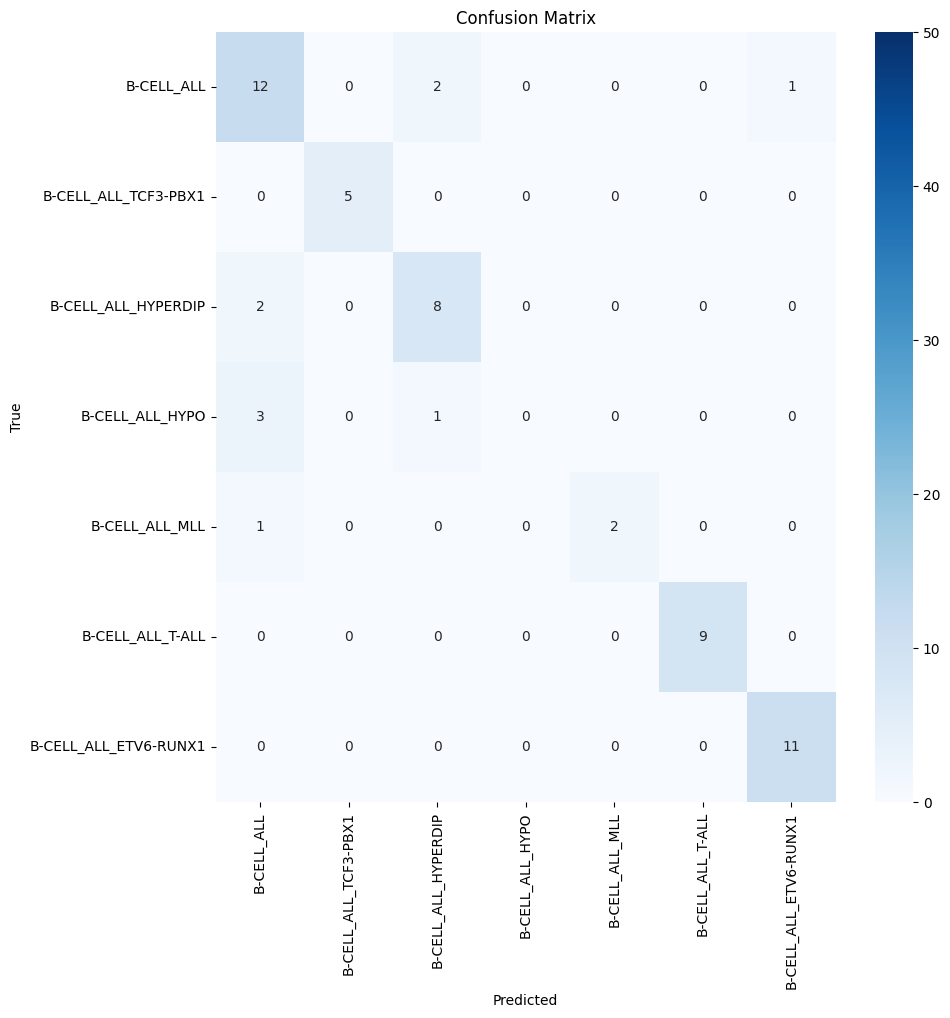

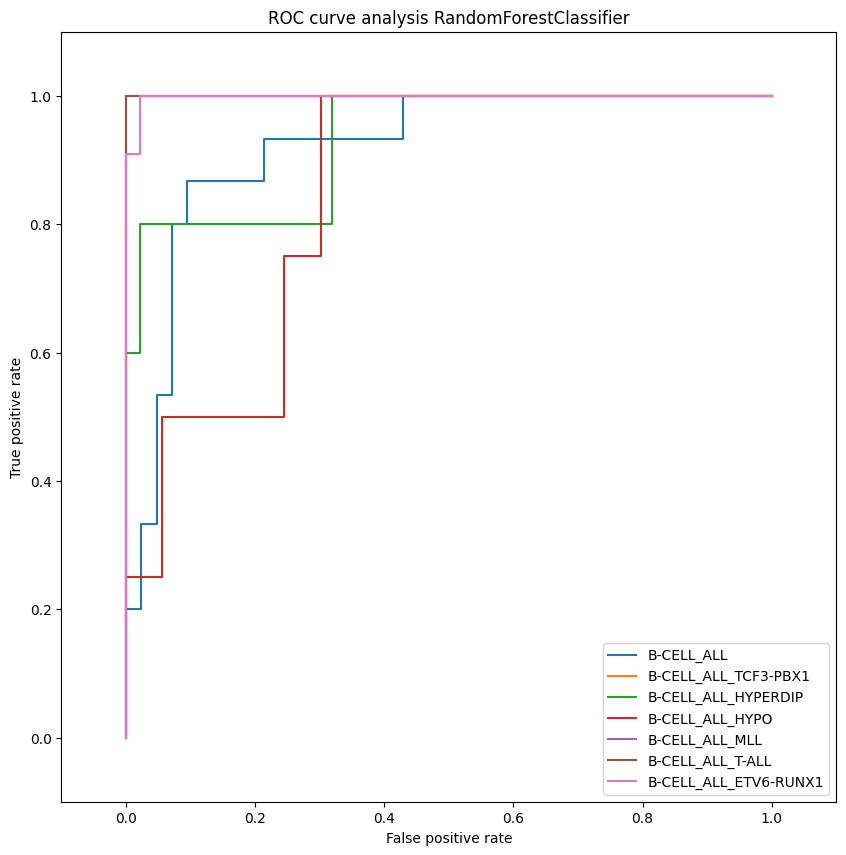

In [4]:
results.loc[len(results)] = pipeline(X_data["leukemia_type"], y_data["leukemia_type"], "RandomForestClassifier", "leukemia_type", classes["leukemia_type"], inv_key_map["leukemia_type"])

(224, 209)


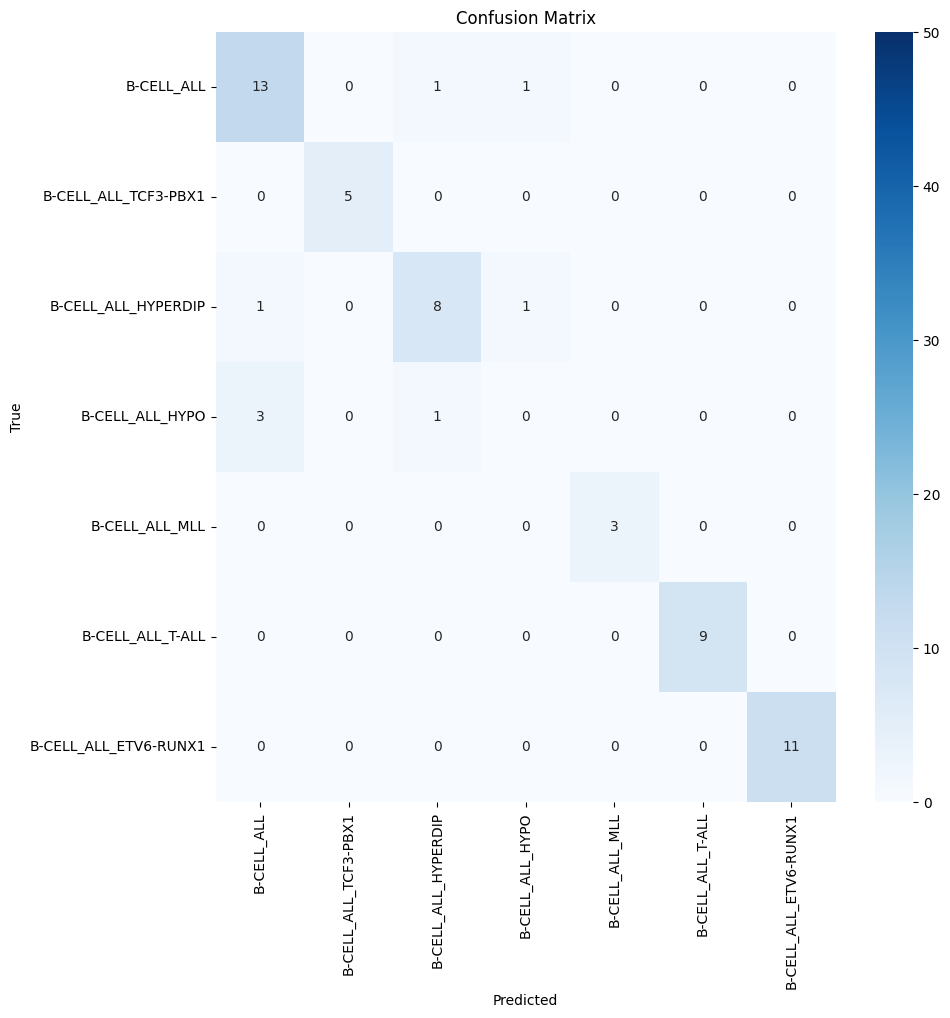

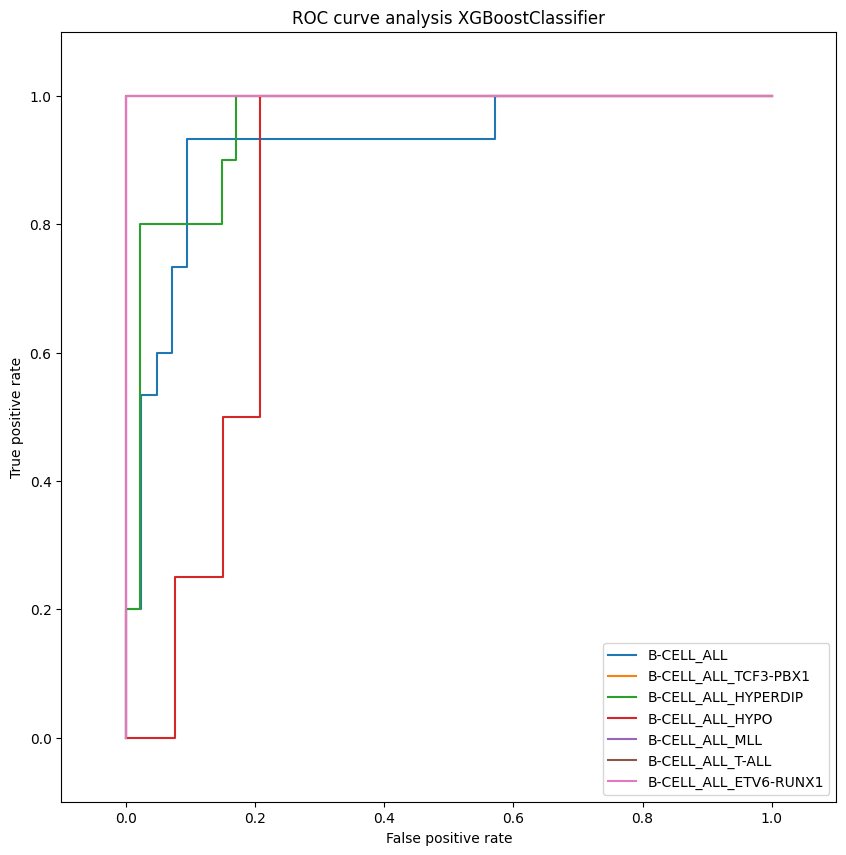

In [9]:
results.loc[len(results)] = pipeline(X_data["leukemia_type"], y_data["leukemia_type"], "XGBoostClassifier", "leukemia_type", classes["leukemia_type"], inv_key_map["leukemia_type"])

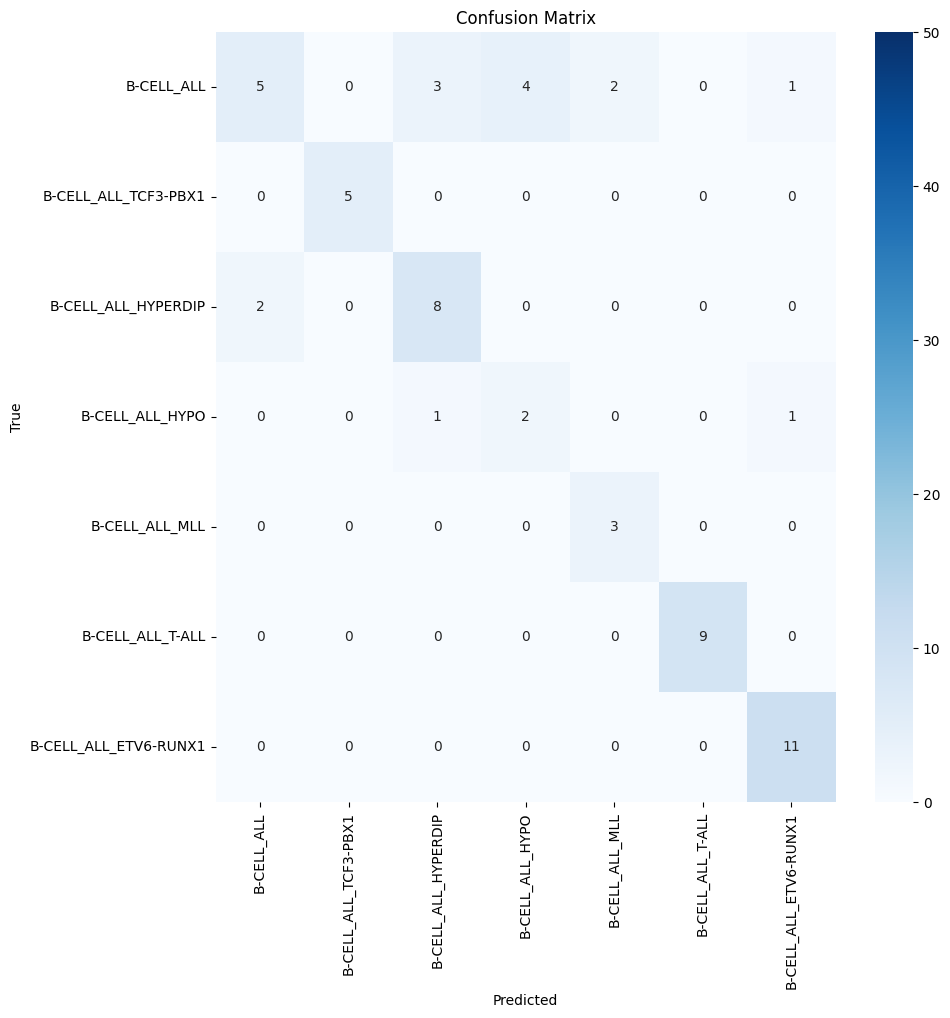

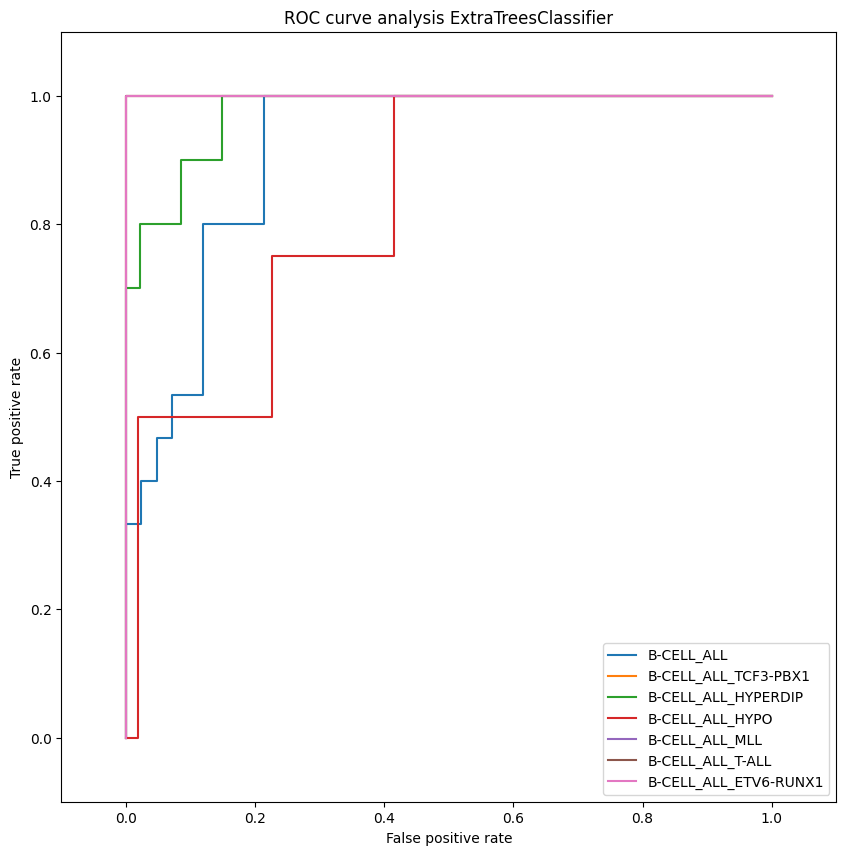

In [10]:
results.loc[len(results)] = pipeline(X_data["leukemia_type"], y_data["leukemia_type"], "ExtraTreesClassifier", "leukemia_type", classes["leukemia_type"], inv_key_map["leukemia_type"])

(93, 42)


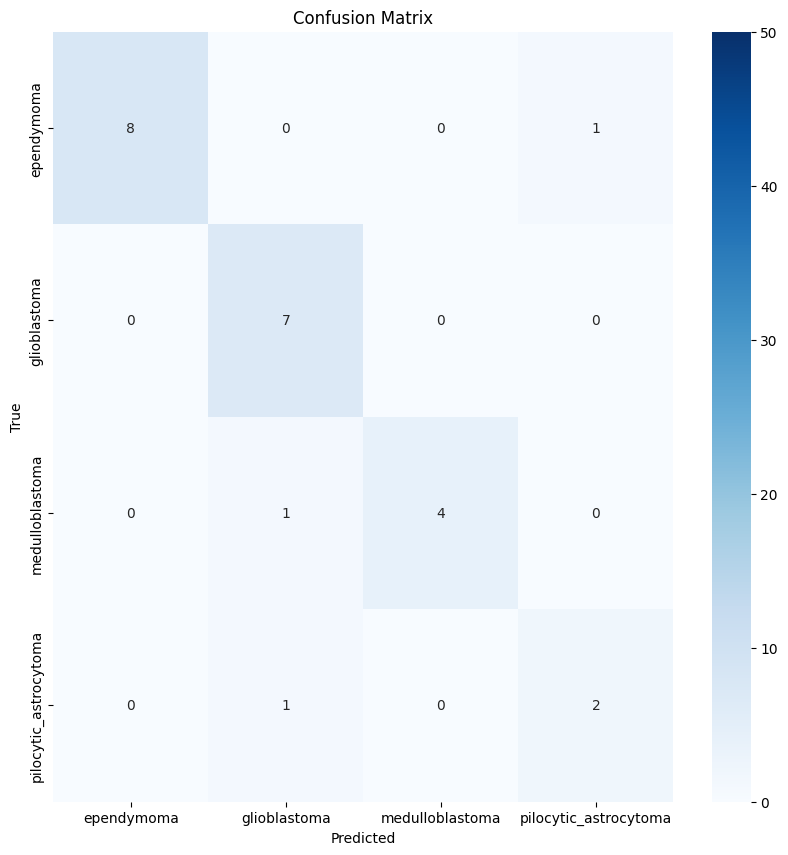

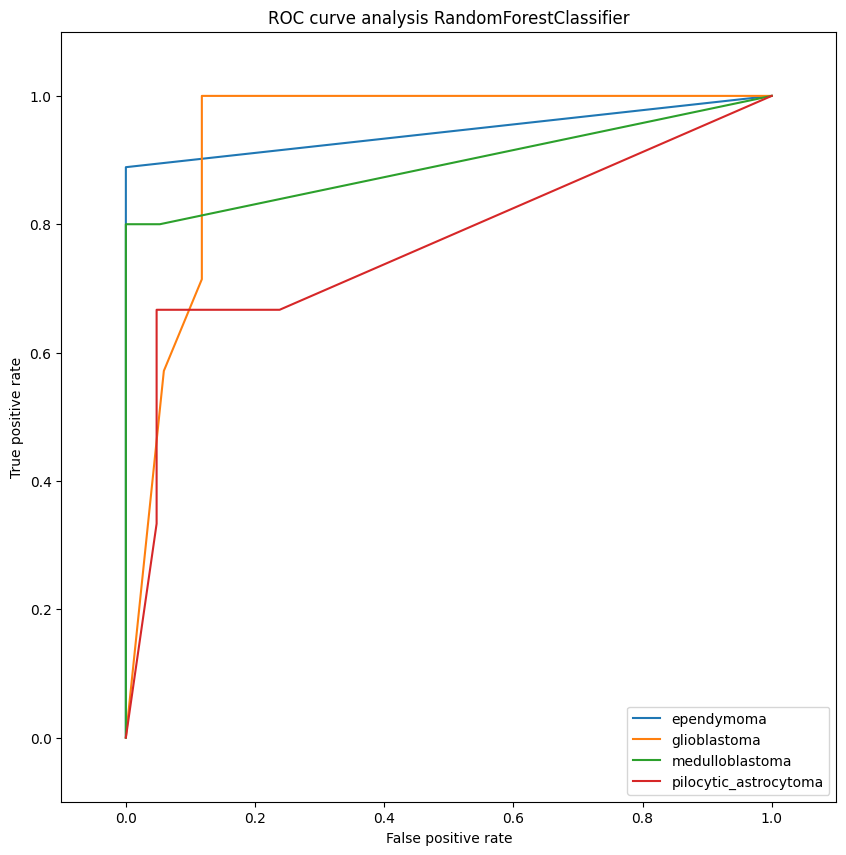

In [10]:
results.loc[len(results)] = pipeline(X_data["brain_type"], y_data["brain_type"], "RandomForestClassifier", "brain_type", classes["brain_type"], inv_key_map["brain_type"])

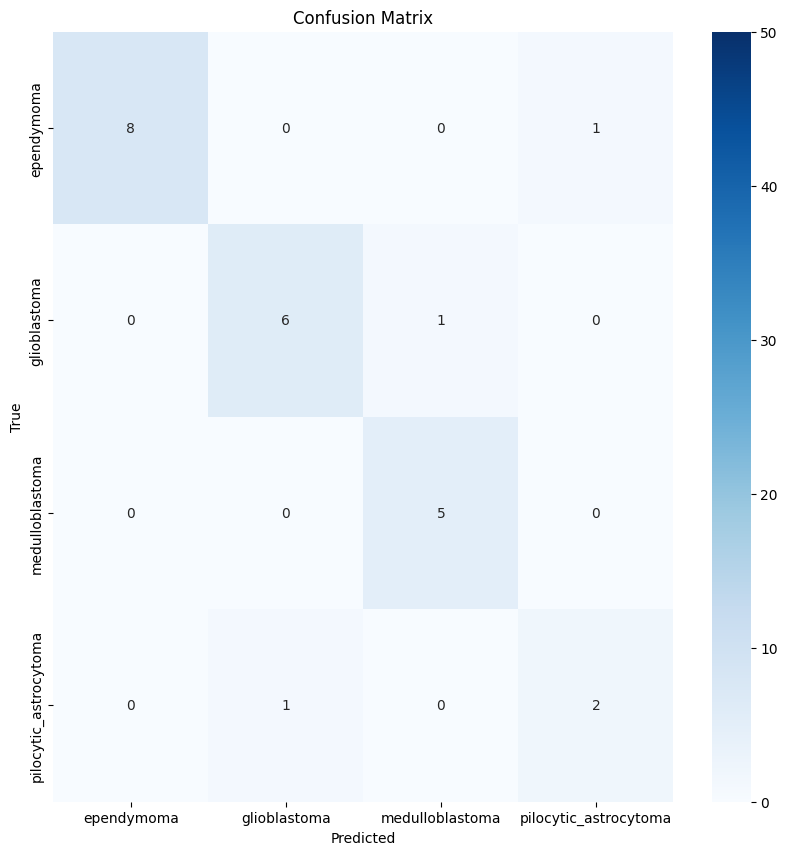

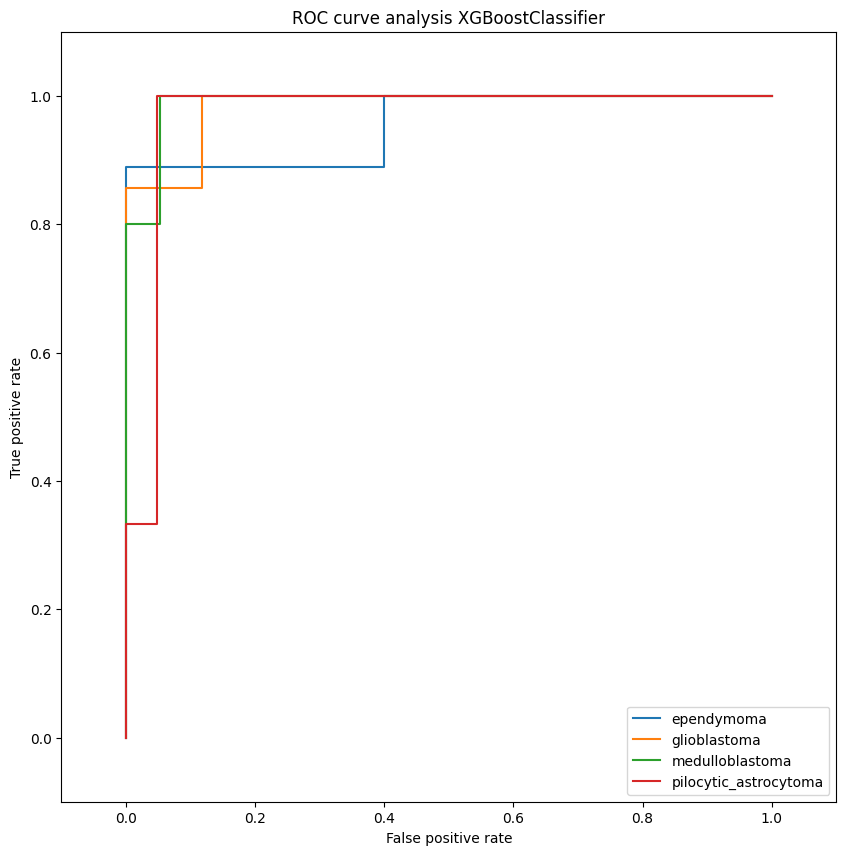

In [12]:
results.loc[len(results)] = pipeline(X_data["brain_type"], y_data["brain_type"], "XGBoostClassifier", "brain_type", classes["brain_type"], inv_key_map["brain_type"])

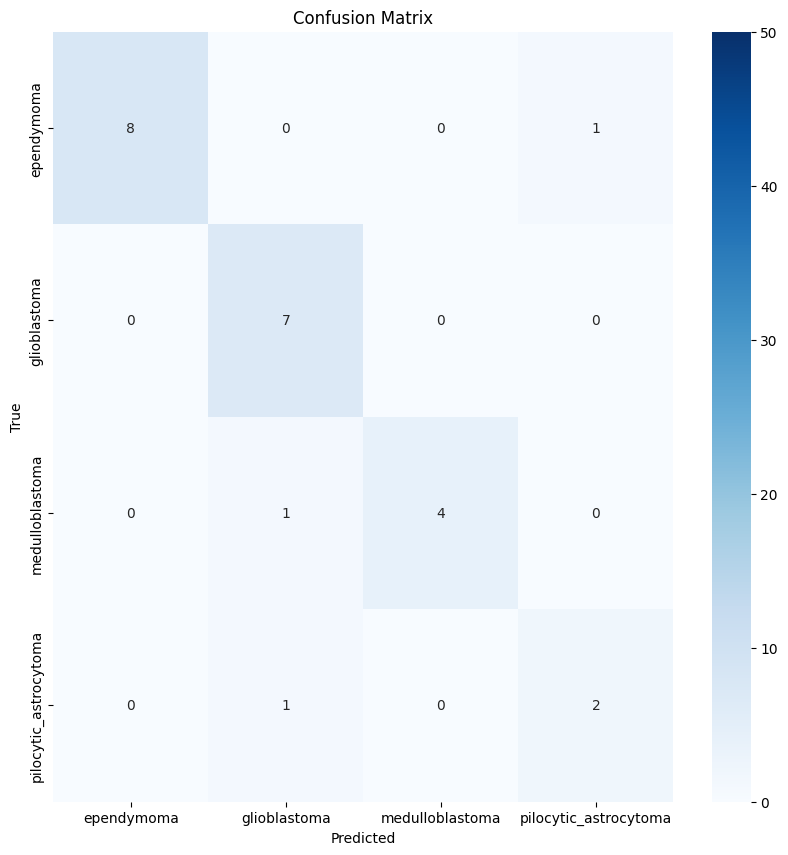

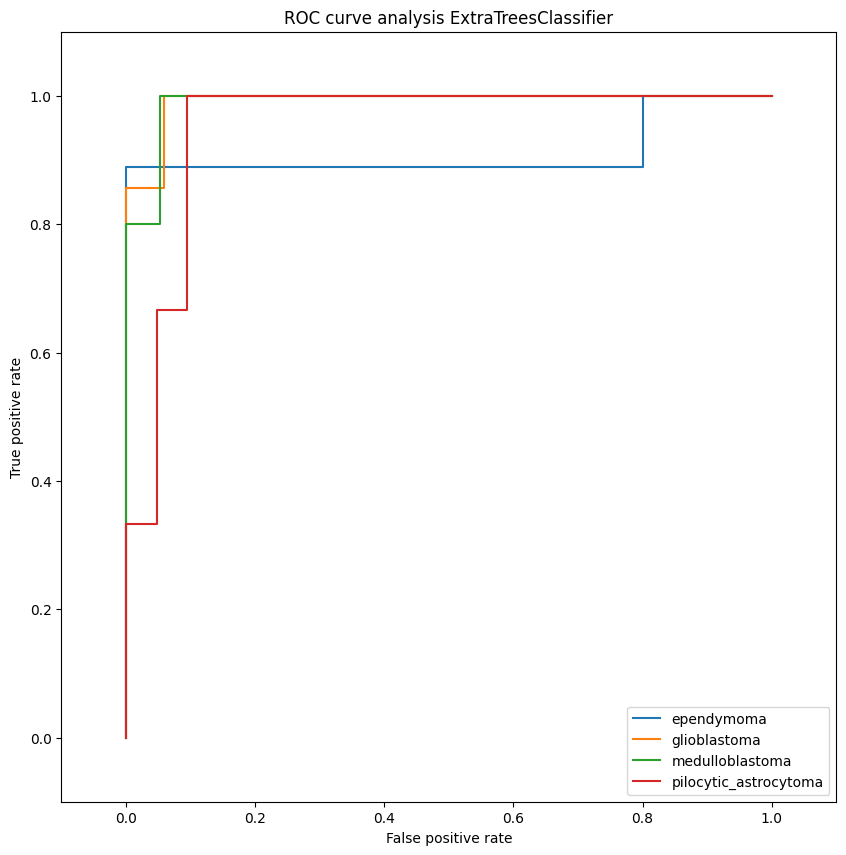

In [13]:
results.loc[len(results)] = pipeline(X_data["brain_type"], y_data["brain_type"], "ExtraTreesClassifier", "brain_type", classes["brain_type"], inv_key_map["brain_type"])

In [14]:
results.to_csv("results/results.csv")
print(results)

                    Model       Database  CV accuracy  CV F1  CV ROC-AUC  \
0  RandomForestClassifier  leukemia_type        0.808  0.770       0.967   
1       XGBoostClassifier  leukemia_type        0.910  0.899       0.985   
2    ExtraTreesClassifier  leukemia_type        0.884  0.875       0.980   
3  RandomForestClassifier     brain_type        0.979  0.978       0.991   
4       XGBoostClassifier     brain_type        0.968  0.968       0.999   
5    ExtraTreesClassifier     brain_type        0.967  0.968       1.000   

   Test accuracy  Test F1  Test ROC-AUC  
0          0.825    0.797         0.956  
1          0.860    0.845         0.960  
2          0.754    0.737         0.961  
3          0.875    0.877         0.911  
4          0.875    0.876         0.972  
5          0.875    0.877         0.956  
